# TensorFlow Basics & Convolution

TensorFlow does not do computation immediately but constructs a graph. We define everything that we want to compute, in a graph and running it requires a session.

### Intro

In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
x = np.linspace(-3, 3, 5) # Computes values immediately
print x

[-3.  -1.5  0.   1.5  3. ]


LinSpace:0 means output of LinSpace. TensorFlow doesn't compute the values immediately. It only specifies the nature of the output of a TF operation, also called an Op node.

In [23]:
x = tf.linspace(-3.0, 3.0, 100) # Doesn't compute immediately
# Note that tf.linspace(-3, 3, 5) gives an error because datatypes are
# mismatched
print (x)

Tensor("LinSpace_2:0", shape=(100,), dtype=float32)


We can get the elements of the graph by doing as follows. We can also get the output of a certain node in the graph

In [9]:
g = tf.get_default_graph()
print [op.name for op in g.get_operations()] # List of ops

# This next step would not work because the tensor doesn't exist yet, we will compute it later.

### print g.get_tensor_by_name('LinSpace_1:0')

# Note that LinSpace has a :0 at the end of it. Without :0, it refers to the Node itself, with :0 it refers to the 
# tensor.

[u'LinSpace/start', u'LinSpace/stop', u'LinSpace/num', u'LinSpace']


### Session
In order to get run a TF program, we need a session. The session computes the graph we construct. Here's an example.

In [13]:
sess = tf.Session()

# We can ask a session to compute the value of a node
computed_x = sess.run(x)
# print (computed_x)

# Or we can ask the node to compute itself using the session
computed_x = x.eval(session = sess)

# print computed_x

# We can close the session by doing this
sess.close()

We can ask TF to create a new graph and have it be connected to another session. We are allowed to have multiple sessions running at the same time.

In [18]:
g = tf.get_default_graph() # Fetch the default graph
g2 = tf.Graph()
print g2

sess2 = tf.Session(graph = g2)
print sess2
sess2.close()

#### Interactive Session - This is a way to run session in environments like notebooks where you don't want to pass around a session variable. But it's just like a session. Here's how to create one. Also this behaves more like a normal python program. You have to recompute the formula if you want updates. For example, z is defined below in the gaussian curve example. You have to rerun the formula after changing x to get new z. Just running z.eval() won't do it. However, in a normal session, it will.

####  Without interactive session, whenever you call x.eval(), you have to pass session as x.eval(session = sess)

In [25]:
sess = tf.InteractiveSession()

# print x.eval()

In [27]:
print x.get_shape() # x.shape
print x.get_shape().as_list() # x.shape.tolist()

(100,)
[100]


### Example - Creating a Gaussian Curve

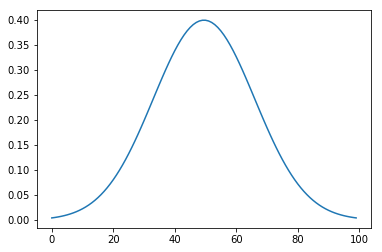

In [30]:
mean = 0
sigma = 1.0
z = 1.0/(tf.sqrt(2*3.14)*sigma) * (tf.exp(-1*(tf.pow(x-mean, 2)/(2*tf.pow(sigma, 2)))))

res = z.eval() # Note that x is already defined from above
plt.plot(res)
plt.show()

### Making it into a 2D Gaussian

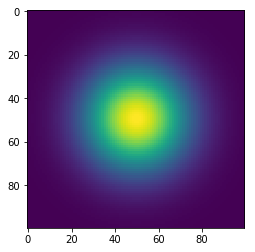

In [31]:
l = z.get_shape().as_list()[0]
res2d = tf.matmul(tf.reshape(z, [l, 1]), tf.reshape(z, [1, l])).eval()
plt.imshow(res2d)
plt.show()

# Convolution

Loading 'camera' images from sklearn

In [39]:
from skimage import data
img = data.camera().astype(np.float32)

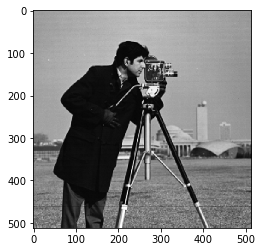

In [34]:
plt.imshow(img, cmap='gray')
plt.show()

#### Convolution operation in TF takes in a 4d tensor for images. The dimensions are (Batch x Height x Width x Channel). Our image is grayscale. So we reshape it using numpy into 4d as shown below.

#### Tensors must be float16, float32 or float64.

In [40]:
# Image shape is 512x512
img4d = tf.reshape(img, [1, img.shape[0], img.shape[1], 1])
print img4d.get_shape()

(1, 512, 512, 1)


#### For the convolution operation we need to provide the specifics of the kernels - Height x Width x Channel x Number of kernels. Let's now convert our gaussian kernel in this format and convolve our image.

In [41]:
l = res2d.shape[0]
kernel = tf.reshape(res2d, [l, l, 1, 1])
print kernel.get_shape()

(100, 100, 1, 1)


In [42]:
# Convolution operation
convolved = tf.nn.conv2d(img4d, kernel, strides = [1, 1, 1, 1],
                        padding = 'SAME')

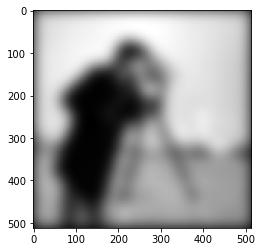

In [43]:
plt.imshow(convolved.eval()[0, :, :, 0], cmap = 'gray')
plt.show()

### Gabor Kernel
#### We can take a sin wave and modulate it with the gaussian kernel to get a gabor kernel. 

In [120]:
ksize = 100
xs = tf.linspace(-3.0, 3.0, ksize)
ys = tf.sin(xs)

# The following two statements are equivalent to 
# plt.plot(xs.eval(), ys.eval())
plt.figure()
plt.plot(ys.eval())

plt.show()

We need to convert this sine wave into a matrix and multiply with the gaussian kernel. That will be the gabor filter. 

In [122]:
ys = tf.reshape(ys, [ksize, 1])
ones = tf.ones([1, ksize])

mat = tf.matmul(ys, ones)
plt.imshow(mat.eval(), cmap = 'gray')
plt.show()

In [127]:
# Multiply with the gaussian kernel
# kernel is 4 dimensional, res2d is the 2d version
gabor = tf.matmul(mat, res2d)
plt.imshow(gabor.eval(), cmap = 'gray')
plt.show()

### Convolution using Placeholders
#### We can specify parameters that we expect to fit in the graph later on, now, by using placeholders. Convolution using placeholders is presented below.

In [128]:
img = tf.placeholder(tf.float32, shape = [None, None], name = 'img')
# Reshaping inbuilt function
img3d = tf.expand_dims(img, 2)
print img3d.get_shape()

img4d = tf.expand_dims(img3d, 0)
print img4d.get_shape()

(?, ?, 1)
(1, ?, ?, 1)


In [129]:
mean = tf.placeholder(tf.float32, name = 'mean')
sigma = tf.placeholder(tf.float32, name = 'sigma')
ksize = tf.placeholder(tf.int32, name = 'ksize')

# Giving formula for x, gaussian kernel, gabor kernel etc..
x = tf.linspace(-3.0, 3.0, ksize)
z = 1.0/(tf.sqrt(2*3.14)*sigma) * (tf.exp(-1*(tf.pow(x-mean, 2)/(2*tf.pow(sigma, 2)))))
z2d = tf.matmul(tf.reshape(z, [ksize, 1]), tf.reshape(z, [1, ksize]))

xs = tf.linspace(-3.0, 3.0, ksize)
ys = tf.sin(xs)

ys = tf.reshape(ys, [ksize, 1])
ones = tf.ones([1, ksize])

mat = tf.matmul(ys, ones)
gabor = tf.matmul(mat, z2d)

gabor4d = tf.reshape(gabor, [ksize, ksize, 1, 1])

convolved = tf.nn.conv2d(img4d, gabor4d, strides = [1, 1, 1, 1],
                        padding = 'SAME')

In [133]:
# We defined the graph above, now we are going to evaluate it. 
result = convolved.eval(feed_dict = {
        img: data.camera(), 
        mean: 0.0, 
        sigma: 1.0, 
        ksize: 5
    })

In [137]:
plt.imshow(result[0, :, :, 0], cmap = 'gray')
plt.title('Gabor filter output')
plt.show()